In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# from catboost import CatBoostClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/application_train.csv')

In [ ]:
data

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data.dtypes

,0
SK_ID_CURR,int64
TARGET,int64
NAME_CONTRACT_TYPE,object
CODE_GENDER,object
FLAG_OWN_CAR,object
...,...
AMT_REQ_CREDIT_BUREAU_DAY,float64
AMT_REQ_CREDIT_BUREAU_WEEK,float64
AMT_REQ_CREDIT_BUREAU_MON,float64
AMT_REQ_CREDIT_BUREAU_QRT,float64


# Графики

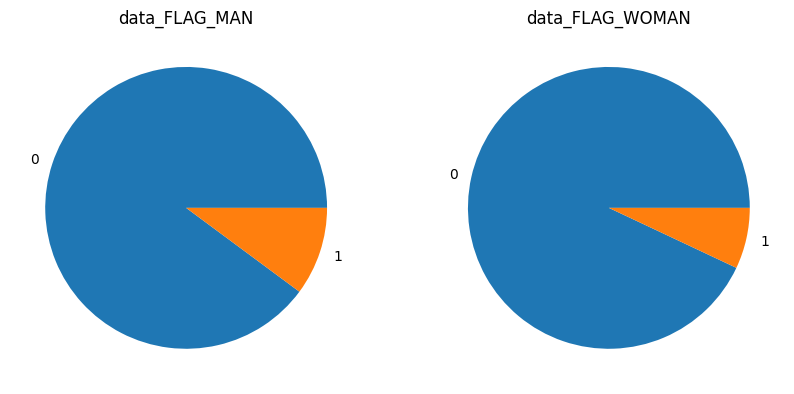

In [ ]:
data_FLAG_MAN = data[data['CODE_GENDER'] == 'M']['TARGET'].value_counts()
data_FLAG_WOMAN = data[data['CODE_GENDER'] == 'F']['TARGET'].value_counts()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.pie(data_FLAG_MAN, labels = data_FLAG_MAN.index)
ax2.pie(data_FLAG_WOMAN, labels = data_FLAG_WOMAN.index)
ax1.set_title('data_FLAG_MAN')
ax2.set_title('data_FLAG_WOMAN')
plt.show()

In [ ]:
data_FLAG_MAN

,count
TARGET,
0,94404
1,10655


In [ ]:
data_FLAG_WOMAN

,count
TARGET,
0,188278
1,14170


# Cat feature selec

In [ ]:
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = data.select_dtypes(include=['object', 'category']).columns

In [ ]:
X_categorical = pd.get_dummies(data[categorical_features])
y = data.TARGET
scaler = MinMaxScaler()
X_numerical_scaled = scaler.fit_transform(data[numerical_features])
X_numerical_scaled = pd.DataFrame(X_numerical_scaled, columns=numerical_features)
X_processed = pd.concat([X_numerical_scaled, X_categorical], axis=1)
selector = SelectKBest(score_func=chi2, k=10)
X_new = selector.fit_transform(X_categorical, y)
selected_features = X_categorical.columns[selector.get_support()]
selected_features

Index(['NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_Working',
       'NAME_EDUCATION_TYPE_Higher education', 'OCCUPATION_TYPE_Drivers',
       'OCCUPATION_TYPE_Laborers', 'ORGANIZATION_TYPE_XNA',
       'WALLSMATERIAL_MODE_Panel'],
      dtype='object')

In [ ]:
from scipy.stats import spearmanr

spearman_scores = X_numerical_scaled.apply(lambda col: spearmanr(col, y).correlation)
top_features = spearman_scores.abs().sort_values(ascending=False).head(10).index

In [ ]:
top_features

Index(['TARGET', 'DAYS_BIRTH', 'REGION_RATING_CLIENT_W_CITY',
       'REGION_RATING_CLIENT', 'DAYS_ID_PUBLISH', 'REG_CITY_NOT_WORK_CITY',
       'FLAG_EMP_PHONE', 'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3',
       'DAYS_REGISTRATION'],
      dtype='object')

In [ ]:
male_credit = data[(data['CODE_GENDER'] == 'M') & (data['TARGET'] == 1)]
female_credit = data[(data['CODE_GENDER'] == 'F') & (data['TARGET'] == 1)]
count_males = male_credit.shape[0]
count_females = female_credit.shape[0]
total_males = data[data['CODE_GENDER'] == 'M'].shape[0]
total_females = data[data['CODE_GENDER'] == 'F'].shape[0]
percent_males = (count_males / total_males) * 100 if total_males > 0 else 0
percent_females = (count_females / total_females) * 100 if total_females > 0 else 0
print(f'Количество мужчин, получающих кредит: {count_males} ({percent_males}%)')
print(f'Количество женщин, получающих кредит: {count_females} ({percent_females}%)')


Количество мужчин, получающих кредит: 10655 (10.141920254333279%)
Количество женщин, получающих кредит: 14170 (6.999328222555916%)


# Нужные столбцы

In [ ]:
columns_to_select = [
    'CODE_GENDER',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'DAYS_BIRTH',
    'AMT_CREDIT',
    'DAYS_EMPLOYED',
    'NAME_CONTRACT_TYPE',
    'NAME_EDUCATION_TYPE',
    'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE',
    'TARGET'
]
necessary_data = data[columns_to_select]
numerical_features = necessary_data.select_dtypes(include=['int64', 'float64']).columns
categorical_features = necessary_data.select_dtypes(include=['object', 'category']).columns
X_categorical = pd.get_dummies(necessary_data[categorical_features])
y = necessary_data.TARGET
scaler = MinMaxScaler()
X_numerical_scaled = scaler.fit_transform(necessary_data[numerical_features])
X_numerical_scaled = pd.DataFrame(X_numerical_scaled, columns=numerical_features)
X_processed = pd.concat([X_numerical_scaled, X_categorical], axis=1)
necessary_data=X_processed.drop(columns=['CODE_GENDER_XNA'])


In [ ]:
necessary_data.iloc[:,7:13]

,CODE_GENDER_F,CODE_GENDER_M,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education
0,False,True,True,False,False,False
1,True,False,True,False,False,True
2,False,True,False,True,False,False
3,True,False,True,False,False,False
4,False,True,True,False,False,False
...,...,...,...,...,...,...
307506,False,True,True,False,False,False
307507,True,False,True,False,False,False
307508,True,False,True,False,False,True
307509,True,False,True,False,False,False


In [ ]:
data_woman_problem = necessary_data[(necessary_data['CODE_GENDER_F']==True)&(necessary_data['TARGET']==1)].drop(columns=['CODE_GENDER_F', 'CODE_GENDER_M'])
data_woman_reliable = necessary_data[(necessary_data['CODE_GENDER_F']==True)&(necessary_data['TARGET']==0)].drop(columns=['CODE_GENDER_F', 'CODE_GENDER_M'])
data_man_problem = necessary_data[(necessary_data['CODE_GENDER_M']==True)&(necessary_data['TARGET']==1)].drop(columns=['CODE_GENDER_F', 'CODE_GENDER_M'])
data_man_reliable = necessary_data[(necessary_data['CODE_GENDER_M']==True)&(necessary_data['TARGET']==0)].drop(columns=['CODE_GENDER_F', 'CODE_GENDER_M'])
data_man_reliable

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_CREDIT,DAYS_EMPLOYED,TARGET,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,NAME_EDUCATION_TYPE_Academic degree,...,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
2,NaN,0.650190,0.814130,0.348534,0.022472,0.046161,0.0,False,True,False,...,True,False,False,False,False,False,False,False,False,False
4,NaN,0.377472,NaN,0.298591,0.116854,0.038820,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
5,NaN,0.414298,0.693145,0.467193,0.111235,0.042604,0.0,True,False,False,...,True,False,False,False,False,False,False,False,False,False
7,NaN,0.835415,0.603169,0.359583,0.370787,0.045577,0.0,True,False,False,...,False,False,True,False,False,False,False,False,False,False
9,NaN,0.873268,NaN,0.606539,0.089888,0.041479,0.0,False,True,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307492,NaN,0.700788,0.407701,0.240361,0.382022,0.042526,0.0,True,False,False,...,False,False,False,False,False,False,True,False,False,False
307494,0.54571,0.818395,0.571049,0.578974,0.108539,0.029594,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
307495,NaN,0.313256,0.666306,0.242785,0.190674,0.027336,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,False
307498,NaN,0.872818,0.453488,0.345378,0.316382,0.037121,0.0,True,False,False,...,True,False,False,False,False,False,False,False,False,False


In [ ]:
X = data_woman_problem.drop(columns='TARGET')
y = data_woman_problem['TARGET']
data_woman_problem_train, data_woman_problem_test, target_woman_problem_train, target_woman_problem_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X = data_woman_reliable.drop(columns='TARGET')
y = data_woman_reliable['TARGET']
data_woman_reliable_train, data_woman_reliable_test, target_woman_reliable_train, target_woman_reliable_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X = data_man_problem.drop(columns='TARGET')
y = data_man_problem['TARGET']
data_man_problem_train, data_man_problem_test, target_man_problem_train, target_man_problem_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X = data_man_reliable.drop(columns='TARGET')
y = data_man_reliable['TARGET']
data_man_reliable_train, data_man_reliable_test, target_man_reliable_train, target_man_reliable_test  = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
quantitative_necessary_data = necessary_data.select_dtypes(include=['float64', 'int64'])
categorical_necessary_data = necessary_data.select_dtypes(include=['object'])

In [ ]:
def sample_data(df, target_value, n_samples):
    return df[df['TARGET'] == target_value].sample(n=n_samples, random_state=42)

n_samples = 2000

def create_balanced_dataset(n_samples):
  woman_problem = sample_data(data_woman_problem, 1, n_samples)
  woman_reliable = sample_data(data_woman_reliable, 0, n_samples)
  man_problem = sample_data(data_man_problem, 1, n_samples)
  man_reliable = sample_data(data_man_reliable, 0, n_samples)
  return pd.concat([woman_problem, woman_reliable, man_problem, man_reliable])

In [ ]:
models = []
for i in range(5):
    balanced_data = create_balanced_dataset(n_samples=4000)
    X = balanced_data.drop(columns='TARGET')
    y = balanced_data['TARGET']

    model = RandomForestClassifier()
    model.fit(X, y)
    models.append(model)

In [ ]:
X_woman.shape[0]

202448

In [ ]:
def predict_ensemble(models, X_test):
    predictions = np.zeros(X_test.shape[0])
    for model in models:
        predictions += model.predict_proba(X_test)[:, 1]  # Вероятность класса 1
    binary_predictions = ((predictions / len(models)) > 0.5).astype(int)
    return binary_predictions

In [ ]:
from sklearn.metrics import classification_report
X_woman = pd.concat([data_woman_problem, data_woman_reliable]).drop(columns='TARGET')
y_woman = pd.concat([data_woman_problem['TARGET'], data_woman_reliable['TARGET']])

X_man = pd.concat([data_man_problem, data_man_reliable]).drop(columns='TARGET')
y_man = pd.concat([data_man_problem['TARGET'], data_man_reliable['TARGET']])


print(classification_report(y_woman, predict_ensemble(models, X_woman)))

print(classification_report(y_man, predict_ensemble(models, X_man)))

              precision    recall  f1-score   support

         0.0       0.97      0.71      0.82    188278
         1.0       0.16      0.73      0.26     14170

    accuracy                           0.71    202448
   macro avg       0.57      0.72      0.54    202448
weighted avg       0.92      0.71      0.78    202448

              precision    recall  f1-score   support

         0.0       0.97      0.63      0.77     94404
         1.0       0.20      0.81      0.32     10655

    accuracy                           0.65    105059
   macro avg       0.58      0.72      0.54    105059
weighted avg       0.89      0.65      0.72    105059



In [ ]:
categorical_necessary_data['OCCUPATION_TYPE'] = categorical_necessary_data['OCCUPATION_TYPE'].fillna('unknown')

In [ ]:
categorical_necessary_data.isna().sum()

,0
NAME_CONTRACT_TYPE,0
NAME_EDUCATION_TYPE,0
NAME_HOUSING_TYPE,0
OCCUPATION_TYPE,0


In [ ]:
quantitative_necessary_data.isna().sum()

,0
EXT_SOURCE_1,173378
EXT_SOURCE_2,660
EXT_SOURCE_3,60965
DAYS_BIRTH,0
AMT_CREDIT,0
DAYS_EMPLOYED,0


In [ ]:
quantitative_necessary_data[quantitative_necessary_data['DAYS_EMPLOYED']>0].DAYS_EMPLOYED

,DAYS_EMPLOYED
8,365243
11,365243
23,365243
38,365243
43,365243
...,...
307469,365243
307483,365243
307487,365243
307505,365243


In [ ]:
quantitative_necessary_data['DAYS_EMPLOYED'] = quantitative_necessary_data['DAYS_EMPLOYED'].apply(lambda x: 0 if x == 365243 else x)

In [ ]:
list_of_EXT_SOURCE = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']
for col in list_of_EXT_SOURCE:
  imp_mode = SimpleImputer(missing_values=np.nan, strategy='mean')
  quantitative_necessary_data[col] = imp_mode.fit_transform(quantitative_necessary_data[col].values.reshape(-1, 1))
columns = quantitative_necessary_data.columns
columns

Index(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'AMT_CREDIT', 'DAYS_EMPLOYED'],
      dtype='object')

In [ ]:
scaler = StandardScaler()
quantitative_scaled_necessary_data = scaler.fit_transform(quantitative_necessary_data)
categorical_encoded_necessary_data = pd.get_dummies(categorical_necessary_data, drop_first=True)
quantitative_scaled_necessary_data = pd.DataFrame(quantitative_scaled_necessary_data, columns=quantitative_necessary_data.columns)
final_data = pd.concat([quantitative_scaled_necessary_data, categorical_encoded_necessary_data], axis=1)
final_data = pd.DataFrame(final_data)

In [ ]:
X_final = final_data
y_final = data.TARGET
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, random_state=42)
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0).fit(X_train, y_train)
y_res = gb_classifier.predict(X_test)
roc_auc_score(y_test, y_res)

np.float64(0.5089558502559978)

In [ ]:
accuracy_score(y_test, y_res)

0.9196779312677229

In [ ]:
class_weights = {0: 1, 1: 9}
import xgboost as xgb
model = xgb.XGBClassifier(scale_pos_weight=9)
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.7319510072976773
